Generate Synthetic Network for OD Estimation Problem

- Simple network with e.g. 3 junction at each an off-ramp and an on-ramp
- Network edge features: length and speed limit
- All road uni-directional in simple toy example - we can extend this later to more complex case of bi-directional roads
- Distinction between fast (main) roads and slow (off/on ramps, minor roads) - this may be more important when route choice introduced
- Output the path incidence matrix and assignment matrix assuming no route choice beyond shortest path
- Generate an OD matrix for the system - e.g. randomly or through some distribution function
- Translate OD matrix to
    - Actual edge level flow
    - INRIX like flow - give x% sample of vehicles in OD matrix a tracker and record their flow
    - MIDAS - record all vehicles at certain points on the network

In [33]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from random import randrange, uniform
from matplotlib import pyplot as plt

def add_gaussian_noise(traffic_data, mean=0, std_dev=1):
    noise = np.random.normal(mean, std_dev)
    return traffic_data + noise

<function matplotlib.pyplot.show(close=None, block=None)>

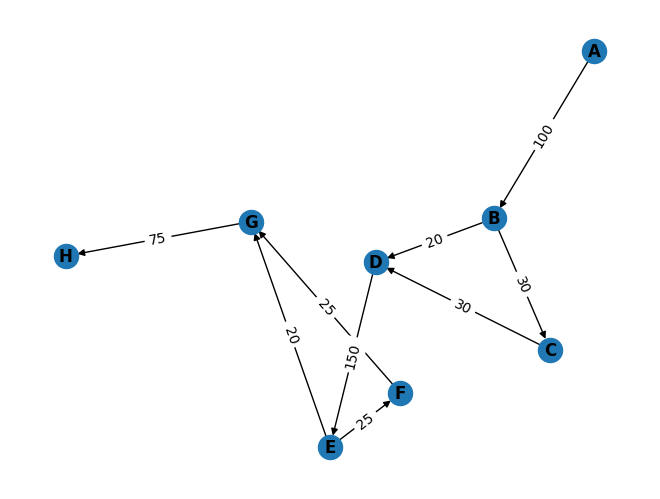

In [2]:
# Create network with 3 junctions

# Create an empty graph
G = nx.DiGraph()

# Add nodes
nodes = ['A','B','C','D','E','F','G','H']
G.add_nodes_from(nodes)

fast_road_sl = 60
slow_road_sl = 30

# Add Edges
edges = [
    #Main road edges
    ('A','B',{'length': 100, 'speed limit': fast_road_sl}),
    ('B','D',{'length': 20, 'speed limit': fast_road_sl}),
    ('D','E',{'length': 150, 'speed limit': fast_road_sl}),
    ('E','G',{'length': 20, 'speed limit': fast_road_sl}),
    ('G','H',{'length': 75, 'speed limit': fast_road_sl}),
    
    #Slow on/off ramps
    ('B','C',{'length': 30, 'speed limit': slow_road_sl}),
    ('C','D',{'length': 30, 'speed limit': slow_road_sl}),
    ('E','F',{'length': 25, 'speed limit': slow_road_sl}),
    ('F','G',{'length': 25, 'speed limit': slow_road_sl})
]

G.add_edges_from(edges)

#Visualise Network

pos = nx.spring_layout(G)  # positions for all nodes

nx.draw(G, pos, with_labels=True, font_weight='bold')

# Edge labels
edge_labels = nx.get_edge_attributes(G, 'length')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show

In [3]:
# Define edge nodes 

NB = ['A','C','F','H']

# Possible destinations for each edge node

NB_Routes = {}
NB_Routes['A'] = ['C','F','H']
NB_Routes['C'] = ['F','H']
NB_Routes['F'] = ['H']
NB_Routes['H'] = []

In [4]:
# Matrices to describe network
# Note that in simple example we assume no route choice variance for OD pairs
# In this case paths IDs will match OD IDs - which won't be the case when route choice included
# E.g., each OD will have multiple possible paths each with a unique ID
# TODO - this code not designed for considering route choice

routes_sp = {}
paths = {}
ods = {}
od_id = 1
path_id = 1

for o in NB:
    destinations = NB_Routes[o]
    if len(destinations) > 0:
        routes_sp[o] = {}
    for d in destinations:
        routes_sp[o][d]=nx.shortest_path(G,o,d,weight = 'length')
        paths[path_id] = tuple([o,d])
        path_id += 1
        ods[tuple([o,d])] = od_id
        od_id += 1

In [5]:
# Get path incidence - (!Assumption - only consider routes that originate at a border node!)

link_path_matrix = pd.DataFrame(0, index = pd.MultiIndex.from_tuples(list(G.edges) ), columns = list(paths.keys()))

for id in list(paths.keys()):
    path = routes_sp[paths[id][0]][paths[id][1]]
    u = path[0]
    for v in path[1:]:
        edge = tuple([u,v])
        link_path_matrix.loc[edge,id] = 1
        u = v

In [6]:
link_path_matrix

1  2  3  4  5  6
A B  1  1  1  0  0  0
B D  0  1  1  0  0  0
  C  1  0  0  0  0  0
C D  0  0  0  1  1  0
D E  0  1  1  1  1  0
E G  0  0  1  0  1  0
  F  0  1  0  1  0  0
F G  0  0  0  0  0  1
G H  0  0  1  0  1  1

In [ ]:
# Get assignment matrix

In [7]:
# Path Proportion Matrix
# A matrix OD ID on the rows, path ID on columns
# Assign proportion of each OD flow to paths IDs
# In simple case, each OD only assigned to one path
# TODO: code not designed for route choice scenario, below code is a cheat

path_od_proportions = pd.DataFrame(0, index = list(paths.keys()), columns = list(ods.values()))
np.fill_diagonal(path_od_proportions.values, 1)

In [8]:
path_od_proportions

,1,2,3,4,5,6
1,1,0,0,0,0,0
2,0,1,0,0,0,0
3,0,0,1,0,0,0
4,0,0,0,1,0,0
5,0,0,0,0,1,0
6,0,0,0,0,0,1


In [9]:
assignment_matrix = np.matmul(link_path_matrix.values,path_od_proportions.values)

In [71]:
assignment_matrix

array([[1, 1, 1, 0, 0, 0],
       [0, 1, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0],
       [0, 1, 1, 1, 1, 0],
       [0, 0, 1, 0, 1, 0],
       [0, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 1, 1]])

### Define An OD Matrix on Area of Study

Naive way:
- Define Total number of vehicles in system
- Distribute with some randomness between all OD pairs

More realistic way
- Assign destinations some "attractiveness" level
- Assign origins some popuation score
- Assign ODs according to some gravity like function using above information

In [10]:
# Naive OD Matrix Consturction
num_v = 5000
inrix_sample_rate = 0.05

# Randomly distribute num_v to OD IDS
od_mx = pd.DataFrame(0,index = list(G.nodes), columns= list(G.nodes))
od_vct = np.zeros((len(ods)))
od_vct_inrix = np.zeros((len(ods)))

for i in range(num_v):
    rnd_var = randrange(len(ods))
    next_od = list(ods.keys())[rnd_var]
    od_mx.loc[next_od[0],next_od[1]] += 1
    od_vct[rnd_var] += 1
    if uniform(0, 1) <= inrix_sample_rate:
        od_vct_inrix[rnd_var] += 1

In [110]:
# TODO - Gravity based OD Matrix

In [11]:
# Function to apply flow to network using assignment matrix

actual_flow = np.matmul(assignment_matrix , od_vct)

In [134]:
#TODO plot on edges as heatmap

### Sensor Readings

1. INRIX sensors
    - Randomly sample agents in OD matrix as being instrumented
    - Apply to edges
2. MIDAS
    - Sense all traffic in set places on network with some smallish error term

In [12]:
inrix_observed_flow = np.matmul(assignment_matrix , od_vct_inrix)

In [13]:
#Taking MIDAS edge as the stretch of road between junction off and on ramps. This closely resembles real-world location of sensors in short straights.
#MIDAS edge : BD, EG
#MIDAS indexes : 1,5

midas_flow1 = add_gaussian_noise(actual_flow[1], mean=0, std_dev=250)
midas_flow2 = add_gaussian_noise(actual_flow[5], mean=0, std_dev=250)

## Iterative Optimisation Routine

- Define a step-size parameter
- Make initial guess as demand vetor usinng a random distribution
- Assign demand to network to get estimated edge level flows
- Calculate edge level residuals
- Calculate od level update vector
    - Matrix multiplication between assignment matrix and residual matrix multiplied by step-size param
    - Careful here - need to check flow conservation is maintained and the demand are always positive
- Repeat until convergence or some stopping criteria is met
  

- Apply updates by matrix multiplying the assignment matrix of edges to OD paths by the residual error on measured flow per edge ($r_a = y_a - \hat{y}_a$)
$$
q^{new}_{i} = q^{old}_{i} + \alpha \sum_k J_{ik} r_k
$$
- Updates may not 

Let to do:

- Build out iterative routine around function developed above
- Put in checks for flow conservations (e.g., sum of update vector = 0, no demand can be negative)
- Clipping of negative demands if neccessary

In [14]:
def get_edge_level_flows(assignment_matrix, demand_vector):
    return np.matmul(assignment_matrix , demand_vector)

def get_residuals(actual_flow, estimated_flow):
    return actual_flow - estimated_flow

def objective_function(actual_flow, estimated_flow):
    return np.sum(get_residuals(actual_flow, estimated_flow)**2)

def get_update_vector(residuals, assignment_matrix):
    return np.matmul(residuals,assignment_matrix)

def stepped_updated_vector(vector, alpha):
    return vector * alpha

def update_od_vector(od_vct_estimate,update_vector_alpha):
    return od_vct_estimate + update_vector_alpha

In [82]:
# Define step size param
alpha = 0.1

#Guess initial demand vector using random distribution
od_hat = np.zeros((len(ods)))
for i in range(num_v):
    rnd_var = randrange(len(ods))
    od_hat[rnd_var] += 1
initial_guess = od_hat.copy()
converged = False

errors = []

iteration = 0

while not converged:
    print('----------')
    print('NEXT ITERATION')
    print('----------')

    #Assign estimated matrix to network to get estimated flows
    estimated_flows = get_edge_level_flows(assignment_matrix, od_hat)

    #Initial objective function
    initial_error = objective_function(actual_flow, estimated_flows)
    print('Objective function at start of iteration : {}'.format(initial_error))

    if iteration == 0:
        errors.append(initial_error)
    
    #Compute residuals
    res_vector = get_residuals(actual_flow, estimated_flows)

    #Map residuals to ODs
    res_to_od = get_update_vector(res_vector, assignment_matrix)

    #Get update vectors
    update_vector = stepped_updated_vector(res_to_od, alpha)

    #Update OD estimates
    new_od_estimate = update_od_vector(od_hat,update_vector)

    #New objective function
    updated_error = objective_function(actual_flow, get_edge_level_flows(assignment_matrix, new_od_estimate))
    print('Objective function at end of iteration : {}'.format(updated_error))
    errors.append(updated_error)
    
    if updated_error < 0.001:
        print('Converge - process stops')
        converged = True

    else:
        print('Not converge - new demand vector passed to next iteration')
        od_hat = new_od_estimate
        iteration += 1

----------
NEXT ITERATION
----------
Objective function at start of iteration : 47373.0
Objective function at end of iteration : 15621.910000000033
Not converge - new demand vector passed to next iteration
----------
NEXT ITERATION
----------
Objective function at start of iteration : 15621.910000000033
Objective function at end of iteration : 9040.860199999997
Not converge - new demand vector passed to next iteration
----------
NEXT ITERATION
----------
Objective function at start of iteration : 9040.860199999997
Objective function at end of iteration : 5528.374079000022
Not converge - new demand vector passed to next iteration
----------
NEXT ITERATION
----------
Objective function at start of iteration : 5528.374079000022
Objective function at end of iteration : 3548.348832409977
Not converge - new demand vector passed to next iteration
----------
NEXT ITERATION
----------
Objective function at start of iteration : 3548.348832409977
Objective function at end of iteration : 2374.7550

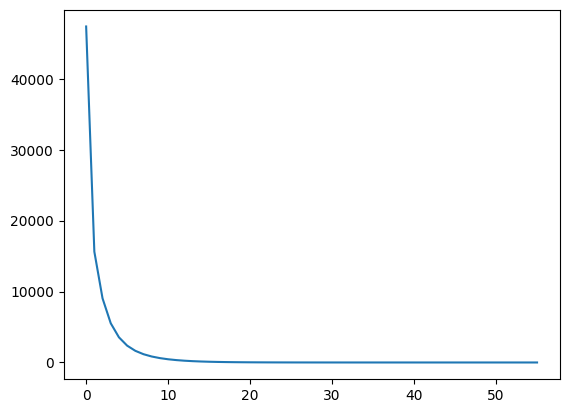

In [83]:
plt.plot(errors)
plt.show()

In [84]:
print('Initial guess correlation to OD ground truth : {}'.format(np.corrcoef(initial_guess,od_vct)[0][1]))
print('OD Estimate correlation to OD ground truth : {}'.format(np.corrcoef(od_hat,od_vct)[0][1]))

Initial guess correlation to OD ground truth : -0.4871082440114938
OD Estimate correlation to OD ground truth : 0.3775272568950943


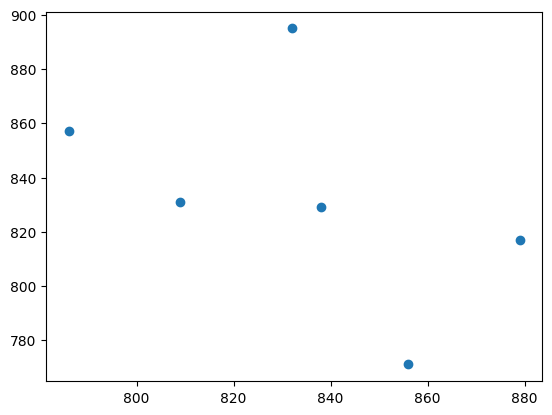

In [85]:
plt.scatter(od_vct,initial_guess)
plt.show()

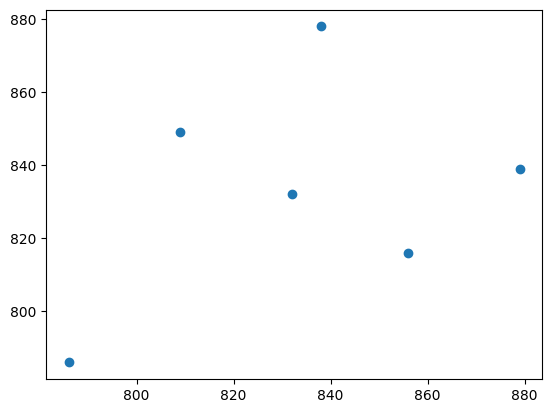

In [86]:
plt.scatter(od_vct,od_hat)
plt.show()

In [79]:
print(od_vct.astype(int))
print(od_hat.astype(int))

[786 879 809 838 856 832]
[786 852 835 864 829 831]


In [81]:
print('Check flow conservation')

print('Actual demand : {}'.format(od_vct.sum()))
print('Estimated demand : {}'.format(od_hat.sum()))

Check flow conservation
Actual demand : 5000.0
Estimated demand : 4999.993009881685


In [88]:
initial_corrs = []
post_corrs = []

for i in range(100):
    
    # Define step size param
    alpha = 0.1

    #Guess initial demand vector using random distribution
    od_hat = np.zeros((len(ods)))
    for i in range(num_v):
        rnd_var = randrange(len(ods))
        od_hat[rnd_var] += 1
    initial_guess = od_hat.copy()
    converged = False

    errors = []

    iteration = 0

    while not converged:
        print('----------')
        print('NEXT ITERATION')
        print('----------')

        #Assign estimated matrix to network to get estimated flows
        estimated_flows = get_edge_level_flows(assignment_matrix, od_hat)

        #Initial objective function
        initial_error = objective_function(actual_flow, estimated_flows)
        print('Objective function at start of iteration : {}'.format(initial_error))

        if iteration == 0:
            errors.append(initial_error)
        
        #Compute residuals
        res_vector = get_residuals(actual_flow, estimated_flows)

        #Map residuals to ODs
        res_to_od = get_update_vector(res_vector, assignment_matrix)

        #Get update vectors
        update_vector = stepped_updated_vector(res_to_od, alpha)

        #Update OD estimates
        new_od_estimate = update_od_vector(od_hat,update_vector)

        #New objective function
        updated_error = objective_function(actual_flow, get_edge_level_flows(assignment_matrix, new_od_estimate))
        print('Objective function at end of iteration : {}'.format(updated_error))
        errors.append(updated_error)
        
        if updated_error < 0.001:
            print('Converge - process stops')
            converged = True

        else:
            print('Not converge - new demand vector passed to next iteration')
            od_hat = new_od_estimate
            iteration += 1
            
            
    initial_corrs.append(np.corrcoef(initial_guess,od_vct)[0][1])
    post_corrs.append(np.corrcoef(od_hat,od_vct)[0][1])

----------
NEXT ITERATION
----------
Objective function at start of iteration : 44505.0
Objective function at end of iteration : 12751.669999999973
Not converge - new demand vector passed to next iteration
----------
NEXT ITERATION
----------
Objective function at start of iteration : 12751.669999999973
Objective function at end of iteration : 8958.347699999998
Not converge - new demand vector passed to next iteration
----------
NEXT ITERATION
----------
Objective function at start of iteration : 8958.347699999998
Objective function at end of iteration : 6450.7935740000175
Not converge - new demand vector passed to next iteration
----------
NEXT ITERATION
----------
Objective function at start of iteration : 6450.7935740000175
Objective function at end of iteration : 4703.776550370017
Not converge - new demand vector passed to next iteration
----------
NEXT ITERATION
----------
Objective function at start of iteration : 4703.776550370017
Objective function at end of iteration : 3458.92

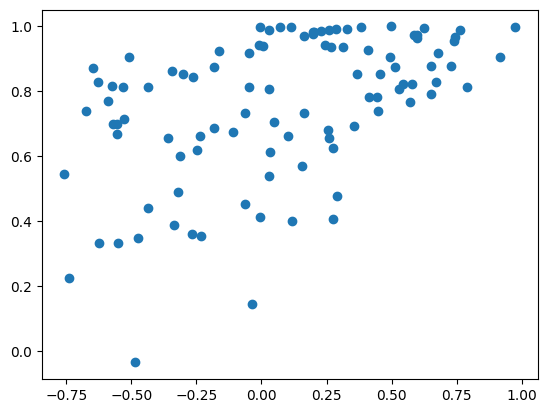

0.4864007779769155


In [91]:
plt.scatter(initial_corrs,post_corrs)
plt.show()

print(np.corrcoef(initial_corrs,post_corrs)[0][1])